In [1]:
from src.thickness_dataset import ThicknessDataset, ToTensor
from src.models import U_Net
from src.trainer import Trainer

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2

PATH = "data\gen_data_6000_v2"

In [2]:
augs = A.Compose([A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(PATH, transform=augs)

# Calculate mean and std
image_loader = DataLoader(thickness_dataset, 
                          batch_size  = 128, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs['img'].sum(axis        = [0, 2, 3])
    psum_sq += (inputs['img'] ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(thickness_dataset) * 128 * 128

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

100%|██████████| 52/52 [00:34<00:00,  1.50it/s]


In [3]:
train_split = 0.7
valid_split = 0.1

HUMAN_SAMPLE_PATH = "data\human_samples"
augs = A.Compose([A.Normalize(mean = total_mean,
                              std  = total_std),
                 ToTensorV2()])
thickness_dataset = ThicknessDataset(HUMAN_SAMPLE_PATH, transform=augs)


test_dataloader = DataLoader(thickness_dataset, batch_size=128)
print("# of samples in test set:", len(thickness_dataset))

# of samples in test set: 10


In [4]:
path = "models\Full train (balanced)\model_20230329-155809_107" ## Fully boi
# path = "models\Partial Train\model_20230303-183712_105"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = U_Net()

criterion = nn.MSELoss()
model = model.to(device)
model.load_state_dict(torch.load(path))
model.eval()
trained_model = model

Using cuda device


In [5]:
# Get the masked loss for the test set quantative evaluation 
# https://torchmetrics.readthedocs.io/en/stable/image/peak_signal_noise_ratio.html
from skimage.metrics import structural_similarity as ssim
from src.evaluation import mse_loss_with_nans
mse_full_loss = 0
mmse_full_loss = 0

batches = 0
loss_fn = torch.nn.MSELoss()
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        outputs = trained_model(images)

        mse_loss = loss_fn(outputs, labels)
        masked_lossv0 = mse_loss_with_nans(outputs, labels)

        mse_full_loss += mse_loss.item()
        mmse_full_loss += masked_lossv0
        batches += 1
print("Test MSE loss: {}".format(mse_full_loss/batches))
print("Test MMSE loss: {}".format(mmse_full_loss/batches))

Test MSE loss: 0.0008149042841978371
Test MMSE loss: 0.00590136693790555


In [6]:
label_dict = {"red": 0, "blue": 1}

df = pd.read_csv("human_sample_actuals.csv", index_col=0)
# sort the idx
df = df.sort_index()
# apply label_dict to label
df["label"] = df["label"].apply(lambda x: label_dict[x])
# convert tuple string to tuple on the thickness column
df["thicker"] = df["thicker"].apply(lambda x: eval(x))
df["thinner"] = df["thinner"].apply(lambda x: eval(x))
# calculate the thickness of the human samples
with torch.no_grad():
    for data in test_dataloader:
        samples = data
        images, labels = data['img'].to(device, dtype=torch.float), data['thick_map'].to(device, dtype=torch.float)
        outputs = trained_model(images)

    # we loop thru every sample in the batch and retrieve the thickness of both points and check that the thicker one is greater than the thinner one
correct = 0
for i in range(labels.cpu().numpy().shape[0]):
    pred = outputs[i].cpu().numpy()
    thicker = df["thicker"][i]
    thinner = df["thinner"][i]
    thick_pred = pred[0][thicker[0]][thicker[1]]
    thin_pred = pred[0][thinner[0]][thinner[1]]
    if thick_pred > thin_pred:
        correct += 1
print("Accuracy: {}".format(correct/labels.cpu().numpy().shape[0]))

Accuracy: 1.0


Correctly predicted 0.4258282 > 0.12544248


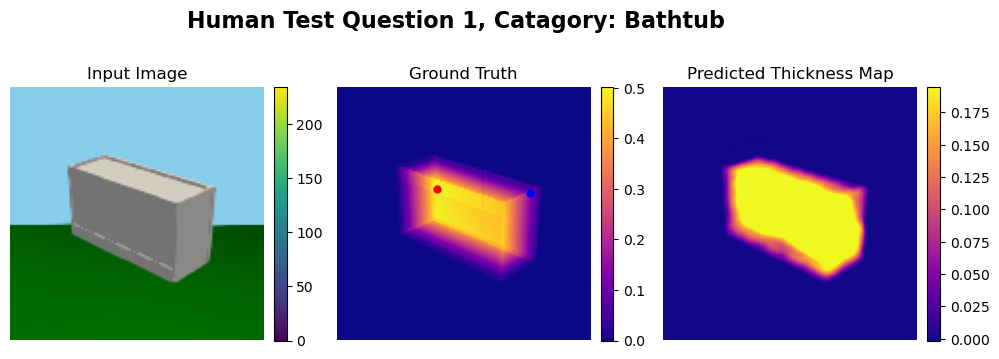

In [34]:
# test visualisation/ qualitative evaluation
from skimage.metrics import structural_similarity as ssim
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
idx = 0
idx_map = {0: "1", 1: "10", 2:"2", 3:"4", 4:"7", 5:"3", 6:"8", 7:"6", 8:"9", 9:"5"}
idx_str = idx_map[idx]
# sample = samples[idx]
output = outputs[idx]
with torch.no_grad():
    image, label = samples['img'][idx].to(device, dtype=torch.float), samples['thick_map'][idx].to(device, dtype=torch.float)
    img_loc = data['img_loc'][idx]
    image = image.cpu().numpy()
    label = label.cpu().numpy()
    output = output.cpu().numpy()
    id = samples['catagory_id'][idx]

    fig = plt.figure(figsize=(12,8))
    grid = ImageGrid(fig, 111,
                        nrows_ncols = (1,3),
                        axes_pad = .5,
                        cbar_location = "right",
                        cbar_mode="each",
                        cbar_size="5%",
                        cbar_pad=0.1,
                    )

    im1 = grid[0].imshow(cv2.cvtColor(cv2.imread(img_loc), cv2.COLOR_BGR2RGB), aspect="equal")
    grid[0].set_title('Input Image')
    grid[0].axis('off')
    grid.cbar_axes[0].colorbar(im1)
    grid.cbar_axes[0].toggle_label(True)
    im2 = grid[1].imshow(labels[idx].cpu().numpy()[0], cmap='plasma')

    thick_pt = df.loc[idx, "thicker"]
    thinner_pt = df.loc[idx, "thinner"]
    grid[1].scatter(thick_pt[1], thick_pt[0], c='r', s=25)
    grid[1].scatter(thinner_pt[1], thinner_pt[0], c='b', s=25)
    
    thickpred = output[0][thick_pt[0]][thick_pt[1]]
    thinnerpred = output[0][thinner_pt[0]][thinner_pt[1]]
    if thickpred > thinnerpred:
        print("Correctly predicted", thickpred, ">", thinnerpred)
    else:
        print("Incorrectly predicted", thickpred, "<", thinnerpred)


    grid[1].set_title('Ground Truth')
    grid[1].axis('off')
    grid.cbar_axes[1].colorbar(im2)

    im3= grid[2].imshow(outputs[idx].cpu().numpy()[0], cmap='plasma',vmax = 0.195)
    grid[2].set_title('Predicted Thickness Map')
    grid[2].axis('off')
    # colorbar of im3 is the same scale as im2 
    grid.cbar_axes[2].colorbar(im3)

    fig.suptitle(f"Human Test Question {idx_str}, Catagory: {thickness_dataset.labels[id].split(',')[0].capitalize()} ", fontsize=16,y=0.75, fontweight = "600")
    plt.show()
    fig.savefig(f'figs\\humans\\human_sample{idx_str}.pdf', bbox_inches='tight')
